# Codes and Outputs for Final Project

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import matplotlib
matplotlib.style.use('ggplot')

from pandas_datareader import data
from datetime import datetime as dt


#### Defining functions to parse 10k files for numbers or words

In [2]:
def parse_for_nums(file_name):
  
    """ 
    TAKES FILENAME AS INPUT AND GIVES ALL NUMBERS IN THAT FILE
    """
    numlist = []
    with open(file_name, 'r') as f:
        for line in f:
            nums = re.findall(re.compile(r'\d+'), line.replace(".",'').replace(',','').upper())
            numlist = numlist + nums
    
    return pd.Series(numlist)



def parse_for_words(file_name):
  
    """ 
    TAKES FILENAME AS INPUT AND GIVES ALL WORDS IN THAT FILE
    """
    wordlist = []
    with open(file_name, 'r') as f:
        for line in f:
            words = re.findall(re.compile('\w+'), line.upper())
            wordlist = wordlist + [word for word in words if word.isdigit()==False]
        
    return pd.Series(wordlist)


def sentiment(word_series):
    
    """
    TAKES A (PANDAS) SERIES OF WORDS AND INPUT AND CALCULATES SENTIMENT SCORES
    """
    positive_words = pd.read_csv('data/LM_poswords.txt', squeeze=True, header=None)
    negative_words = pd.read_csv('data/LM_negwords.txt', squeeze=True, header=None)

    positive_count = sum(word_series.isin(positive_words))
    negative_count = sum(word_series.isin(negative_words))

    print 'Sentiment Values:\ni) positive - negative / total :{}\nii) negative / total words : {}'.\
                format((positive_count-negative_count)/float(len(word_series)), negative_count/float(len(word_series)))

#### Defining function to check a number list for Benford's law

In [3]:
def get_signif(string):
    
    """
    TAKES THE STRING OF A NUMBER AS INPUT AND RETURNS THE FIRST SIGNIFICANT DIGIT IN THE NUMBER
    """
    diglist = re.findall(re.compile(r'[1-9]'),string)
    if diglist == []:
        return np.nan
    else:
        return diglist[0]


def obeys_benford(num_series):
    
    """
    TAKES A PANDAS SERIES OF NUMBERS AS INPUT AND TESTS FOR BENFORD'S LAW
    """
    
    expected_dist = pd.Series([np.log10(1+(1/float(d))) for d in range(1,10)]
                                   ,index = range(1,10)).cumsum()
    first_digits_counts = num_series.map(get_signif).dropna().astype(int).value_counts().sort_index()
    
    first_digits_cumfreq = (first_digits_counts/first_digits_counts.sum()).cumsum()
    
    ks_stat = (expected_dist.subtract(first_digits_cumfreq)).abs().max()
    cutoff = 1.36/np.sqrt(len(num_series))
    
    print 'ks_stat: {}'.format(round(ks_stat,3))
    print 'cutoff : {}'.format(round(cutoff,3))    
    
    if ks_stat > cutoff:
        print 'These numbers do not obey Benford\'s Law'
    else:
        print 'These numbers obey Benford\'s Law'

# Benford's law

### Netflix

First off, trying the entire 10k

In [4]:
obeys_benford(parse_for_nums('data/nflx-10k.txt'))

ks_stat: 0.128
cutoff : 0.025
These numbers do not obey Benford's Law


Next, trying only the key financial statements

In [5]:
obeys_benford(parse_for_nums('data/nflx-10k-nums.txt'))

ks_stat: 0.068
cutoff : 0.076
These numbers obey Benford's Law


### Time Warner Inc

In [6]:
obeys_benford(parse_for_nums('data/twx-10k-nums.txt'))

ks_stat: 0.014
cutoff : 0.025
These numbers obey Benford's Law


### Amazon

In [7]:
obeys_benford(parse_for_nums('data/amzn-10k-nums.txt'))

ks_stat: 0.049
cutoff : 0.073
These numbers obey Benford's Law


# Sentiment analysis

## Management and Discussion

### Netflix

In [8]:
sentiment(parse_for_words('data/nflx-mgmtdisc.txt'))

Sentiment Values:
i) positive - negative / total :0.000445434298441
ii) negative / total words : 0.00400890868597


### Time Warner

In [9]:
sentiment(parse_for_words('data/twx-mgmtdisc.txt'))

Sentiment Values:
i) positive - negative / total :0.00024931438544
ii) negative / total words : 0.0074794315632


### Amazon

In [10]:
sentiment(parse_for_words('data/amzn-mgmtdisc.txt'))

Sentiment Values:
i) positive - negative / total :0.018261504748
ii) negative / total words : 0.00438276113952


## Risk Factors

### Netflix

In [11]:
sentiment(parse_for_words('data/nflx-riskfactors.txt'))

Sentiment Values:
i) positive - negative / total :-0.0325497287523
ii) negative / total words : 0.0443733481708


### Time Warner

In [12]:
sentiment(parse_for_words('data/twx-riskfactors.txt'))

Sentiment Values:
i) positive - negative / total :-0.0232996402261
ii) negative / total words : 0.0388898406716


### Amazon

In [13]:
sentiment(parse_for_words('data/amzn-riskfactors.txt'))

Sentiment Values:
i) positive - negative / total :-0.0271548436308
ii) negative / total words : 0.0396643783371


## Foward-looking statement for Netflix

In [14]:
sentiment(parse_for_words('data/nflx-fwd-looking.txt'))

Sentiment Values:
i) positive - negative / total :0.0204703832753
ii) negative / total words : 0.00522648083624





## Sentiment vs RoA

The sentiment score considered for this is the Net sentiment

In [15]:
companies = ['Netflix Inc.', 'Amazon.com Inc.', 'Time Warner Inc.']

sentiment_scores = [0.00044,0.01826,0.00025]
ROA = [-0.07345,0.18214,0.06002]


plot_df = pd.DataFrame({'Sentiment':sentiment_scores,
                        'ROA': ROA},
                      index = companies)

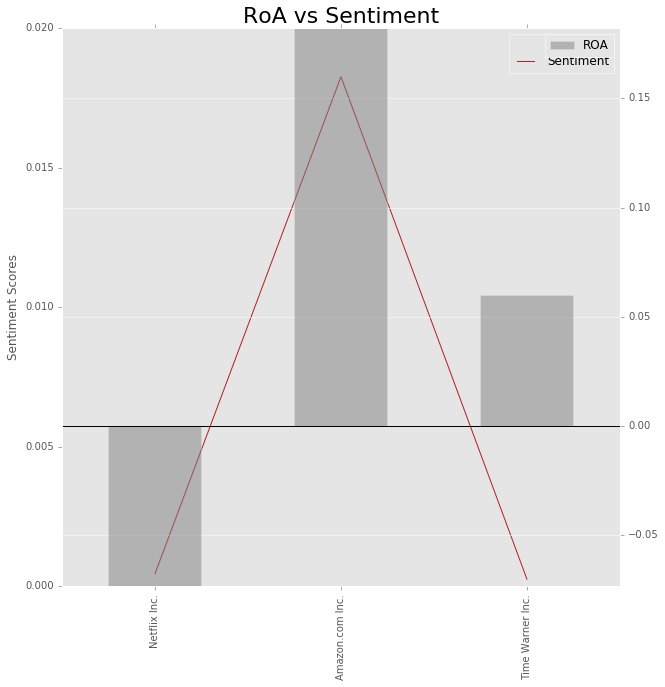

In [16]:
%matplotlib inline

plot_df.Sentiment.plot(color = 'firebrick',grid = 'off',figsize = (10,10), stacked= True)
plt.ylabel('Sentiment Scores')
plt.legend(loc = 'upper left')
plot_df.ROA.plot(kind = 'bar', color = 'gray',secondary_y = True,grid = 'off',stacked = False, alpha = 0.5)
plt.axhline(color='k')
plt.legend()
plt.grid(True)
plt.margins(1,0)
plt.title('RoA vs Sentiment',{'fontsize':22})
#plt.savefig('ROAvSentiment.png')

## Netflix stock performance plot

In [17]:
start = dt(2005,12,31)

nflx_stock_close = data.DataReader('nflx','google',start)['Close']

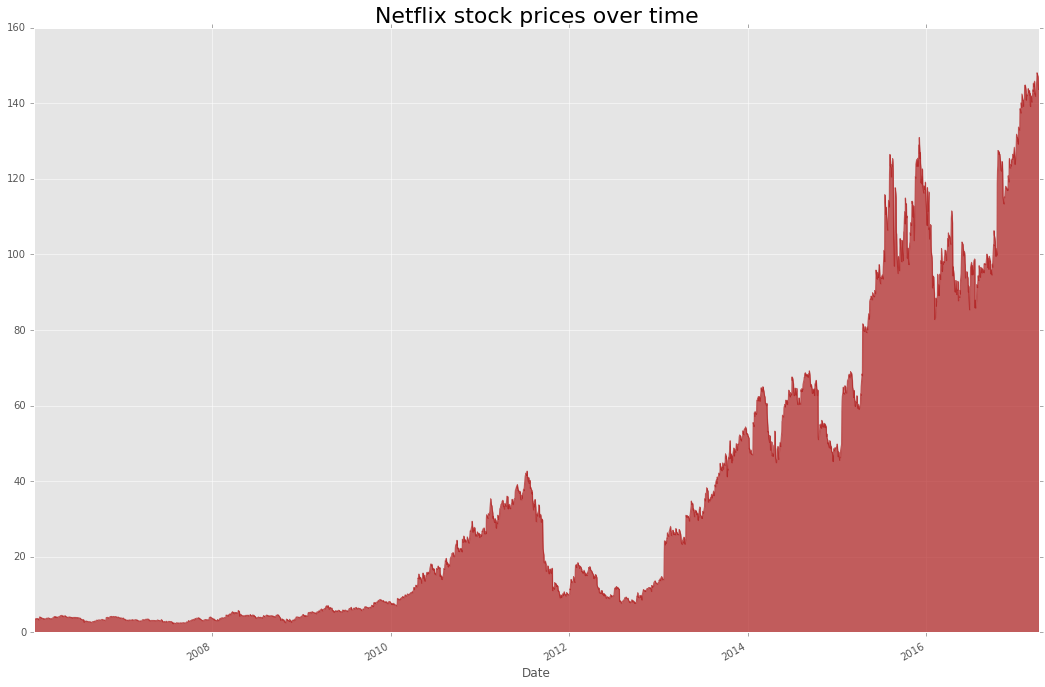

In [18]:
%matplotlib inline

nflx_stock_close.plot(kind='area',
                      color = 'firebrick',
                      alpha=0.7,
                      figsize = (18,12))

plt.title('Netflix stock prices over time',fontdict={'fontsize':22})
#plt.savefig('nflx_stock_price.png')